# Seleccion de las variables categoricas para el modelo

Ya tenemos las variables numericas con las que vamos a intentar predecir el 'Price_euros' sin embargo cual o cuales de las variables categoricas son las mas optimas para tomarlas en cuenta y con ellas predecir precio (estas ya cuentan con un analsis) pero aqui queremos dar un efoque estadistico a su eleccion 

Primero partamos con las graficas de caja y bigotes relacionadas con 'Price_euros' para verlas nuevamente estos seran clave ya que visualizarlos nos ayuda a intuir que prueba estadistica pudieramos usar para escojer las variables categoricas predicctoras del modelo

In [9]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_laptops = pd.read_csv("dataset/df_model_ready.csv")

categorical_vars = [
    'Company', 'TypeName', 'OS', 'PrimaryStorageType',
    'SecondaryStorageType', 'CPU_company', 'GPU_company'
]

C:\Users\delhy.py\AppData\Local\Temp\ipykernel_7436\120970901.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y=dependent_var_transformed, data=df_laptops, palette='rainbow')
C:\Users\delhy.py\AppData\Local\Temp\ipykernel_7436\120970901.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y=dependent_var_transformed, data=df_laptops, palette='rainbow')
C:\Users\delhy.py\AppData\Local\Temp\ipykernel_7436\120970901.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y=dependent_var_transformed, data=df_laptops, palet

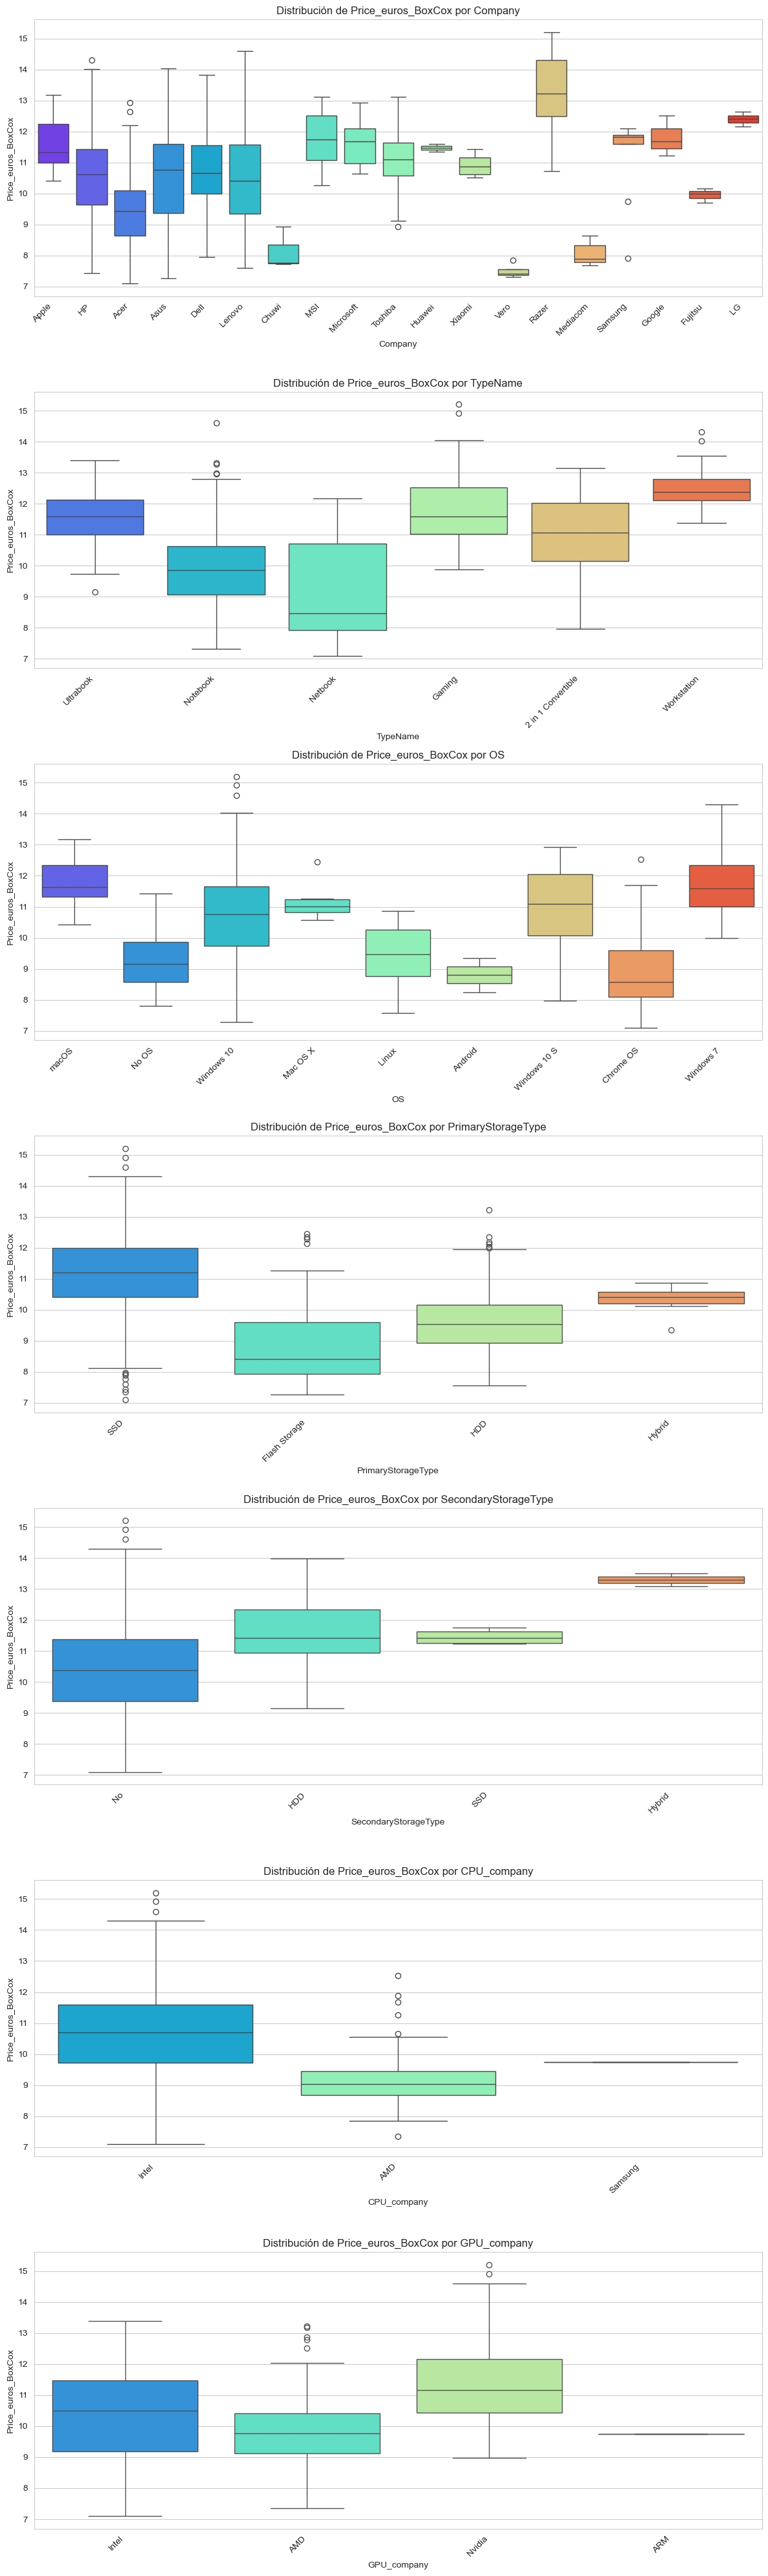

In [10]:
# Variable dependiente transformada (Box-Cox)
dependent_var_transformed = 'Price_euros_BoxCox'

# Configurar el estilo de los gráficos
sns.set_style("whitegrid")
plt.figure(figsize=(12, 40)) # Ajusta el tamaño general de la figura

# Generar un gráfico de caja y bigotes para cada variable categórica
for i, col in enumerate(categorical_vars):
    plt.subplot(len(categorical_vars), 1, i + 1) # Crea un subgráfico para cada variable
    sns.boxplot(x=col, y=dependent_var_transformed, data=df_laptops, palette='rainbow')
    plt.title(f'Distribución de {dependent_var_transformed} por {col}')
    plt.xlabel(col)
    plt.ylabel(f'{dependent_var_transformed}')
    plt.xticks(rotation=45, ha='right') # Rota las etiquetas del eje x para mejor legibilidad

plt.tight_layout() # Ajusta automáticamente los parámetros para que las subtramas encajen en la figura
plt.show()

Los graficos son claros y ya nos hacen intuir de cierta forma que existen diferencias entre los distintos grupos que presenta cada variable categorica

Vamos a ver tras haber visto los graficos de caja y bigote, ver si se cumplen los supuestos de Analisis de Varianza (ANOVA) para poder escojer posteriormente las variables categoricas de nuestro modelo o si en su defecto tenemos que aplicar otra prueba estadistica

In [11]:
# Variable dependiente transformada
dependent_var = 'Price_euros_BoxCox'

# Diccionario para almacenar los resultados de los supuestos
anova_assumptions_results = {
    'Variable Categórica': [],
    'Normalidad (Shapiro-Wilk) - ¿Sí/No?': [],
    'Homogeneidad de Varianzas (Levene) - ¿Sí/No?': []
}

# Umbral de significancia para las pruebas (p-value)
alpha = 0.05

print(f"Verificando supuestos de ANOVA para '{dependent_var}'...\n")

for col in categorical_vars:
    anova_assumptions_results['Variable Categórica'].append(col)
    print(f"--- Analizando: {col} ---")

    # 1. Verificamos Normalidad (por grupo si es posible, o en los residuos del modelo si hay muchos grupos)
    # Para la normalidad, un enfoque común es verificar los residuos de un modelo lineal simple.
    # Sin embargo, con muchos grupos pequeños, es más robusto verificar la normalidad de los residuos generales
    # o de cada grupo si son lo suficientemente grandes.
    # Una forma práctica es verificar si la distribución global de Price_euros_BoxCox es normal,
    # y luego si los residuos del modelo ANOVA son normales.
    # Para fines de simplificar el chequeo por grupo: si un grupo es muy pequeño, Shapiro-Wilk puede fallar.
    # En la práctica, se suele aceptar cierta desviación de la normalidad si el tamaño de la muestra es grande
    # debido al Teorema del Límite Central.

    # Intentaremos verificar la normalidad para cada grupo si tiene al menos 50 observaciones para Shapiro-Wilk
    normalidad_cumple = True
    unique_groups = df_laptops[col].unique()
    for group in unique_groups:
        group_data = df_laptops[df_laptops[col] == group][dependent_var].dropna()
        if len(group_data) >= 5: # Mínimo 5 observaciones para Shapiro-Wilk
            stat, p_shapiro = stats.shapiro(group_data)
            if p_shapiro < alpha:
                normalidad_cumple = False
                # print(f"  - Normalidad FALLA para el grupo '{group}' (p={p_shapiro:.4f})")
                break # Si un grupo falla, el supuesto no se cumple estrictamente para la variable
        # else:
            # print(f"  - Grupo '{group}' tiene pocas observaciones ({len(group_data)}), no se puede evaluar normalidad robustamente.")

    anova_assumptions_results['Normalidad (Shapiro-Wilk) - ¿Sí/No?'].append("Sí" if normalidad_cumple else "No")


    # 2. Verificamos Homogeneidad de Varianzas (Test de Levene)
    # Prepara los datos para la prueba de Levene
    data_for_levene = [df_laptops[df_laptops[col] == group][dependent_var].dropna() for group in unique_groups]
    # Filtra grupos vacíos si los hubiera
    data_for_levene = [group_data for group_data in data_for_levene if len(group_data) > 1] # Levene necesita al menos 2 observaciones por grupo

    if len(data_for_levene) > 1: # Necesitamos al menos dos grupos para Levene
        stat_levene, p_levene = stats.levene(*data_for_levene)
        if p_levene > alpha:
            anova_assumptions_results['Homogeneidad de Varianzas (Levene) - ¿Sí/No?'].append("Sí")
        else:
            anova_assumptions_results['Homogeneidad de Varianzas (Levene) - ¿Sí/No?'].append("No")
        # print(f"  - Test de Levene (Homogeneidad de Varianzas): p={p_levene:.4f} {'(Cumple)' if p_levene > alpha else '(Falla)'}")
    else:
        anova_assumptions_results['Homogeneidad de Varianzas (Levene) - ¿Sí/No?'].append("N/A (pocos grupos)")
        # print(f"  - No hay suficientes grupos para el Test de Levene.")
    print("-" * 25)

# Crear el DataFrame de resultados
results_df = pd.DataFrame(anova_assumptions_results)
print("\n--- Tabla de Verificación de Supuestos de ANOVA ---")
print(results_df.to_markdown(index=False))

Verificando supuestos de ANOVA para 'Price_euros_BoxCox'...

--- Analizando: Company ---
-------------------------
--- Analizando: TypeName ---
-------------------------
--- Analizando: OS ---
-------------------------
--- Analizando: PrimaryStorageType ---
-------------------------
--- Analizando: SecondaryStorageType ---
-------------------------
--- Analizando: CPU_company ---
-------------------------
--- Analizando: GPU_company ---
-------------------------

--- Tabla de Verificación de Supuestos de ANOVA ---
| Variable Categórica   | Normalidad (Shapiro-Wilk) - ¿Sí/No?   | Homogeneidad de Varianzas (Levene) - ¿Sí/No?   |
|:----------------------|:--------------------------------------|:-----------------------------------------------|
| Company               | No                                    | No                                             |
| TypeName              | No                                    | No                                             |
| OS                

Dado que los supuestos de ANOVA no se cumplen vamos a aplicar la prueba Kruskal-Wallis H para saber si  existen difencias entre almenos 2 categorias de cada variable categorica

In [ ]:
# Nivel de significancia
alpha = 0.05

# Diccionario para almacenar los resultados
kruskal_results = {
    'Variable Categórica': [],
    'Estadístico H (Kruskal-Wallis)': [],
    'Valor p': [],
    '¿Existe Diferencia Estadística? (p < 0.05)': []
}

print(f"Aplicando la Prueba de Kruskal-Wallis H para '{dependent_var}'...\n")

for col in categorical_vars:
    # Obtenemos los grupos de datos para la prueba de Kruskal-Wallis
    # Aseguramos de que no haya grupos vacíos y que cada grupo tenga datos
    groups = [df_laptops[df_laptops[col] == category][dependent_var].dropna() for category in df_laptops[col].unique()]
    
    # Filtramos grupos con menos de 2 observaciones, ya que Kruskal-Wallis necesita al menos 2
    # para calcular rangos correctamente dentro de cada grupo.
    valid_groups = [group_data for group_data in groups if len(group_data) >= 2]

    # Solo realizar la prueba si hay al menos dos grupos válidos
    if len(valid_groups) >= 2:
        try:
            stat, p_value = stats.kruskal(*valid_groups)
            diff_exists = "Sí" if p_value < alpha else "No"
        except ValueError as e:
            # Capturamos errores si un grupo tiene valores constantes, lo que puede ocurrir
            # si todos los valores de Price_euros_BoxCox en un grupo son idénticos.
            print(f"Advertencia: No se pudo calcular Kruskal-Wallis para {col} debido a un error: {e}")
            stat, p_value = np.nan, np.nan
            diff_exists = "N/A (Error de cálculo)"
    else:
        stat, p_value = np.nan, np.nan
        diff_exists = "N/A (Pocos grupos válidos)"
        print(f"Advertencia: No hay suficientes grupos válidos (al menos 2 con >=2 observaciones) para {col}.")


    kruskal_results['Variable Categórica'].append(col)
    kruskal_results['Estadístico H (Kruskal-Wallis)'].append(f"{stat:.4f}" if not np.isnan(stat) else "N/A")
    kruskal_results['Valor p'].append(f"{p_value:.4f}" if not np.isnan(p_value) else "N/A")
    kruskal_results['¿Existe Diferencia Estadística? (p < 0.05)'].append(diff_exists)

# Creamos el DataFrame de resultados
results_df = pd.DataFrame(kruskal_results)

print("\n--- Resultados de la Prueba de Kruskal-Wallis H ---")
print(results_df.to_markdown(index=False))


Aplicando la Prueba de Kruskal-Wallis H para 'Price_euros_BoxCox'...


--- Resultados de la Prueba de Kruskal-Wallis H ---
| Variable Categórica   |   Estadístico H (Kruskal-Wallis) |   Valor p | ¿Existe Diferencia Estadística? (p < 0.05)   |
|:----------------------|---------------------------------:|----------:|:---------------------------------------------|
| Company               |                         220.375  |         0 | Sí                                           |
| TypeName              |                         545.561  |         0 | Sí                                           |
| OS                    |                         184.571  |         0 | Sí                                           |
| PrimaryStorageType    |                         463.931  |         0 | Sí                                           |
| SecondaryStorageType  |                         145.151  |         0 | Sí                                           |
| CPU_company           |            

Gracias al resultado de la prueba anterior llegamos a la conclusion de que todas las variables categoricas son importantes para la contruccion del modelo y de hecho no hay que crear un nuevo csv porque el que ya tenemos tiene todo lo necesario

Ahora el siguiente paso es pasar a la construccion del modelo de regresion lineal multiple